Transfer learning reduces the training time and data needed to achieve a custom task. It takes a CNN that has been pre-trained (typically ImageNet), removes the last fully-connected layer and replaces it with our custom fully-connected layer, treating the original CNN as a feature extractor for the new dataset. Once replaced the last fully-connected layer we train the classifier for the new dataset.

# Image classification with transfer learning

In [ ]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import np_utils


def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test
      


# Data preprocessing

In [ ]:
import cv2

(x_train_rgb, y_train), (x_test_rgb, y_test) = cifar10.load_data()
print(x_train_rgb.shape)


x_train = np.array([cv2.resize(img,(75,75)) for img in x_train_rgb[:,:,:,:]])
x_test = np.array([cv2.resize(img,(75,75)) for img in x_test_rgb[:,:,:,:]])
print(x_train.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

learning_rate = 1e-4
lr_decay = 1e-6
lr_drop = 20
batch_size = 32
epochs = 25

'''def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)'''

(50000, 32, 32, 3)
(50000, 75, 75, 3)


# Model customization

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


img_rows, img_cols, img_channel = 75, 75, 3
weight_decay = 0.0005

base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
#for layer in base.layers:
#    layer.trainable = False

top_model = Sequential()
top_model.add(Flatten(input_shape=base.output_shape[1:]))
top_model.add(Dense(512, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(weight_decay)))
top_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base.input, outputs=top_model(base.output))

ssgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
#ssgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=ssgd,metrics=['accuracy'])

model.summary()

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_____

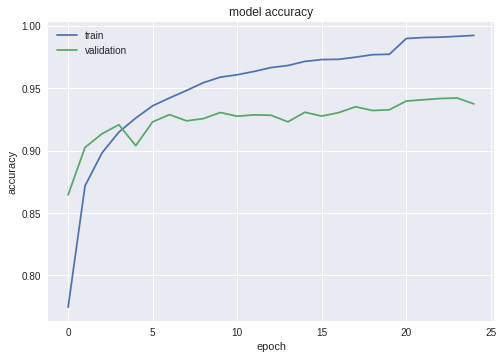

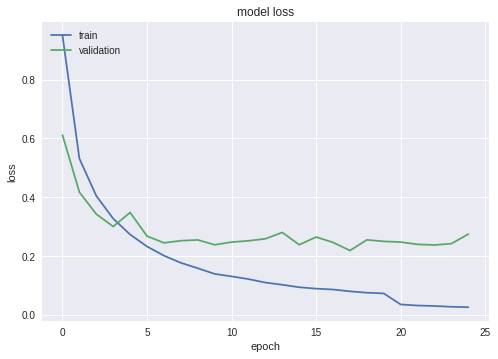

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
 model.save_weights('/content/drive/My Drive/deep_color/RGB/vgg16_RGB_25.h5')

In [ ]:
predicted_x = model.predict(x_test,batch_size= 50)
residuals = np.argmax(predicted_x,1)!=np.argmax(y_test,1)
loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ",loss)

the validation 0/1 loss is:  0.0624


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 16s 2ms/step
Test loss: 0.27505670336410404
Test accuracy: 0.9376


In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(x_test,batch_size= 32)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_test = np.argmax(y_test,axis = 1)
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)

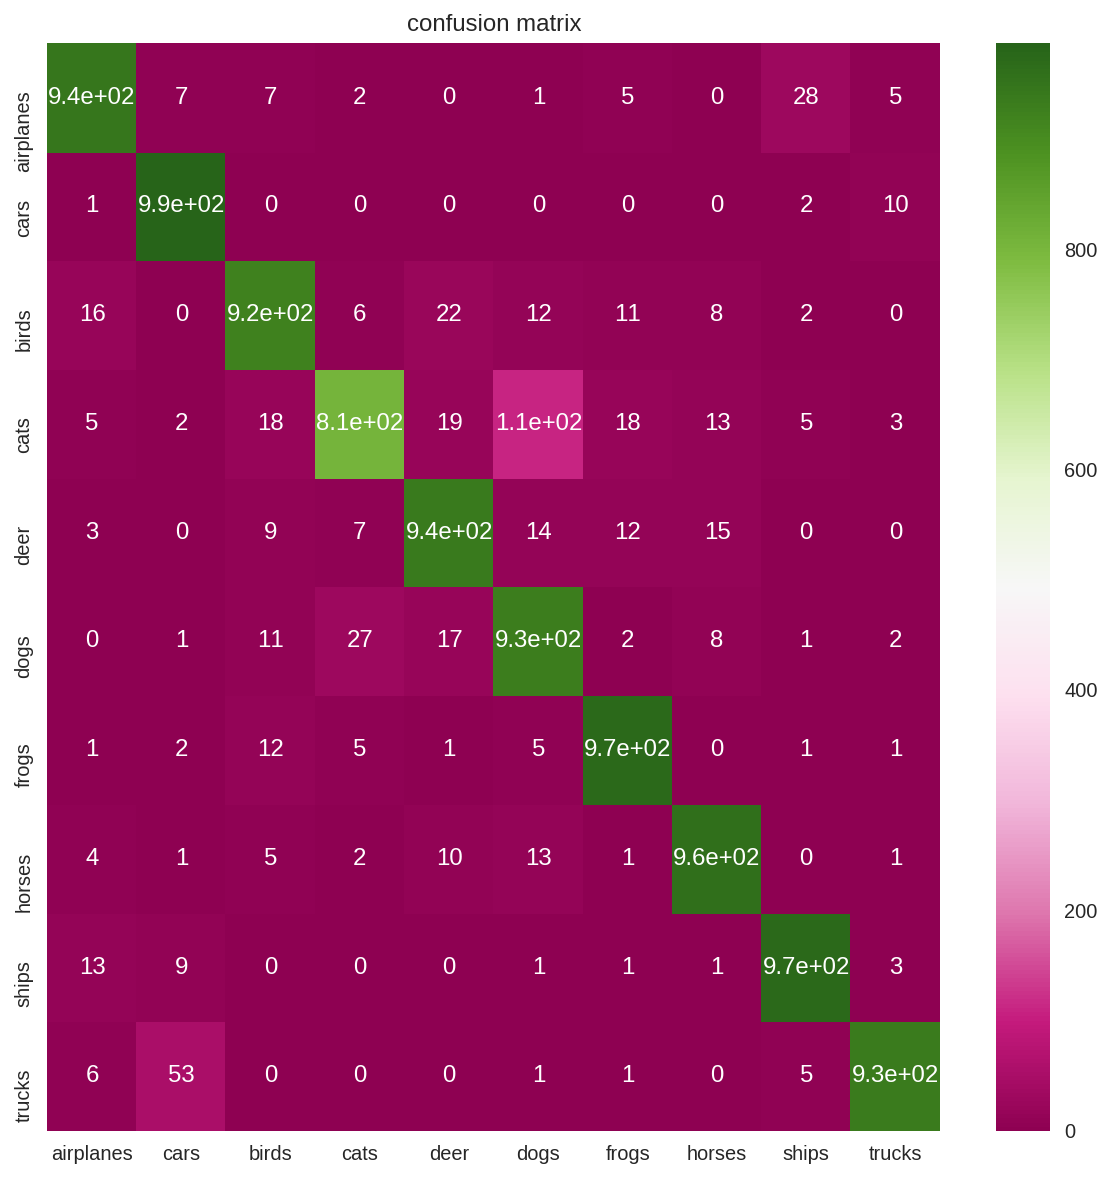

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
classes = ['airplanes' , 'cars' , 'birds' , 'cats' , 'deer' , 'dogs' , 'frogs' , 'horses' , 'ships' , 'trucks' ]
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix,cmap = "PiYG", annot = True , xticklabels=classes,
            yticklabels=classes)
plt.title("confusion matrix")
plt.show()

# Data Augmentation

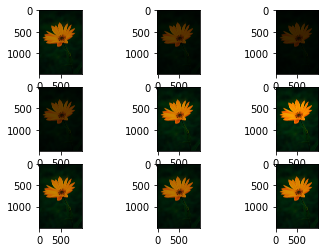

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('flower.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
#datagen = ImageDataGenerator(width_shift_range=[-200,200])
#datagen = ImageDataGenerator(rotation_range=90)
#datagen = ImageDataGenerator(horizontal_flip=True)
datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

In [ ]:
train_generator = datagen.flow_from_directory(
                  directory=home_path + r'/train/',
                  target_size=(160, 160), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="binary", # classes to predict
                  seed=2020 # to make the result reproducible
                  )

model.fit_generator(train_generator, 
                    epochs=epochs,  # one forward/backward pass of training data
                    steps_per_epoch=x_train.shape[0]//batch_size,  # number of images comprising of one epoch
                    validation_data=(x_test, y_test), # Or validation_data=valid_generator
                    validation_steps=x_test.shape[0]//batch_size)

# DenseNet block

In [ ]:
def dense_factor(inputs):
    h_1 = BatchNormalization()(inputs)
    h_1 = Conv2D(12, (3,3), border_mode='same')(h_1)
    output = ReLU()(h_1)
    return output

def dense_block(inputs):

    concatenated_inputs = inputs

    for i in range(3):
        x = dense_factor(concatenated_inputs)
        concatenated_inputs = concatenate([concatenated_inputs, x], axis=3)

    return concatenated_inputs

# Skip Connections

Skip Connections (or Shortcut Connections) as the name suggests skips some of the layers in the neural network and feeds the output of one layer as the input to the next layers. Skip Connections were introduced to solve different problems in different architectures such as degradation problem, feature reusability, etc.

Variants of skip connections 
* Residual Networks
* DenseNet

DenseNets uses Concatenation whereas ResNets uses Summation

ResNet: skip connections via addition 
* The core idea is to backpropagate through the identity function, by just using a vector addition. Then the gradient would simply be multiplied by one and its value will be maintained in the earlier layers.

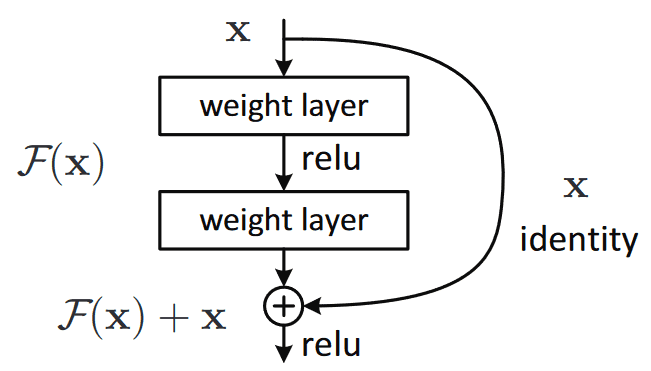

DenseNet: skip connections via concatenation 
* The alternative way that you can achieve skip connections is by concatenation of previous feature maps. The most famous deep learning architecture is DenseNet. This architecture heavily uses feature concatenation so as to ensure maximum information flow between layers in the network. This is achieved by connecting via concatenation all layers directly with each other, as opposed to ResNets.

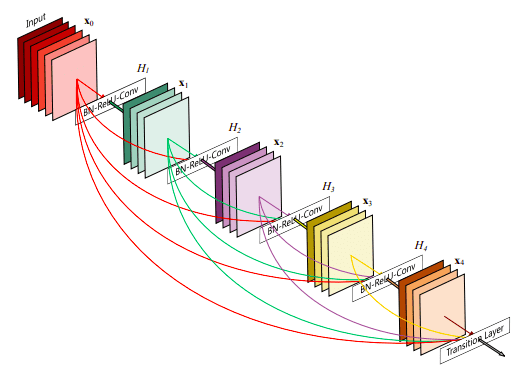

In ResNet architecture, a “shortcut” or a “skip connection” allows the gradient to be directly backpropagated to earlier layers:

In [ ]:
from tensorflow.keras import layers

def residual_block(x, filters):
    fx = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(fx)
    fx = layers.BatchNormalization()(fx)
    #out = layers.Add()([x,fx])
    out = layers.Concatenate()([x,fx])
    out = layers.ReLU()(out)
    return out


In [ ]:
input_layer = Input(shape=(32,32,3,))
x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(input_layer)
x = residual_block(x, 32)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
x = residual_block(x, 64)
#x = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)
#x = residual_block(x, 128)
x = Flatten()(x)
x = Dense(units=84, activation="relu")(x)
x = Dense(units=10, activation="softmax")(x)

model = Model(inputs=input_layer, outputs = x)
print(model.summary())

#model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics="acc")

#history = model.fit(x=trainX, y=trainY, batch_size=256, epochs=10, validation_data=(testX, testY))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   896         ['input_3[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_15[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                              

Task to perform - 
* Make your own model to experiment with skip connections